In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, norm, chi2, uniform, t, f

# 1. 計算檢定統計量 G3 的函數 G3_stats(X)
def G3_stats(X):
    """
    Input:
        X: A numpy array of shape (N, n) where N is the number of samples and n is the size of each sample
    Output:
        G3: A numpy array of shape (N,) that contains the G3 statistic for each sample
        P_Val: A numpy array of shape (N,) that contains the p-value for each sample
    """
    n = X.shape[1]
    G1 = np.sqrt(n / 6) * skew(X, axis = 1, bias = False) # bias = False 表示 Unbiased
    G2 = np.sqrt(n / 24) * (kurtosis(X, axis = 1, bias = False, fisher = True))
    G3 = G1**2 + G2**2
    P_Val = 1 - chi2.cdf(G3, df = 2) # chi2.cdf 是指從 0 到 G3 的面積，1 - chi2.cdf 是指從 G3 到無限大的面積
    return G3, P_Val

distributions = {
    'N(0, 1)': lambda size: norm.rvs(loc = 0, scale = 1, size = size),
    'T(3)': lambda size: t.rvs(df = 3, size = size),
    'T(10)': lambda size: t.rvs(df = 10, size = size),
    'T(30)': lambda size: t.rvs(df = 30, size = size),
    'Unif(0, 1)': lambda size: uniform.rvs(loc = 0, scale = 1, size = size),
    '$\chi^2(4)$': lambda size: chi2.rvs(df = 4, size = size),
    '$\chi^2(8)$': lambda size: chi2.rvs(df = 8, size = size),
    '$\chi^2(20)$': lambda size: chi2.rvs(df = 20, size = size),
    'F(10, 10)': lambda size: f.rvs(dfn = 10, dfd = 10, size = size),
    'F(50, 50)': lambda size: f.rvs(dfn = 50, dfd = 50, size = size)
}


# 2. 快速選擇所需分配的函數 dist(dist_name, N, n)
def dist(dist_name, N, n):
    """
    Input:
        dist_name: A string that represents the distribution name
        N: The number of samples
        n: The size of each sample
    Output:
        distributions[dist_name]((N, n)): A numpy array of shape (N, n) that contains the random samples
    """
    return distributions[dist_name]((N, n))

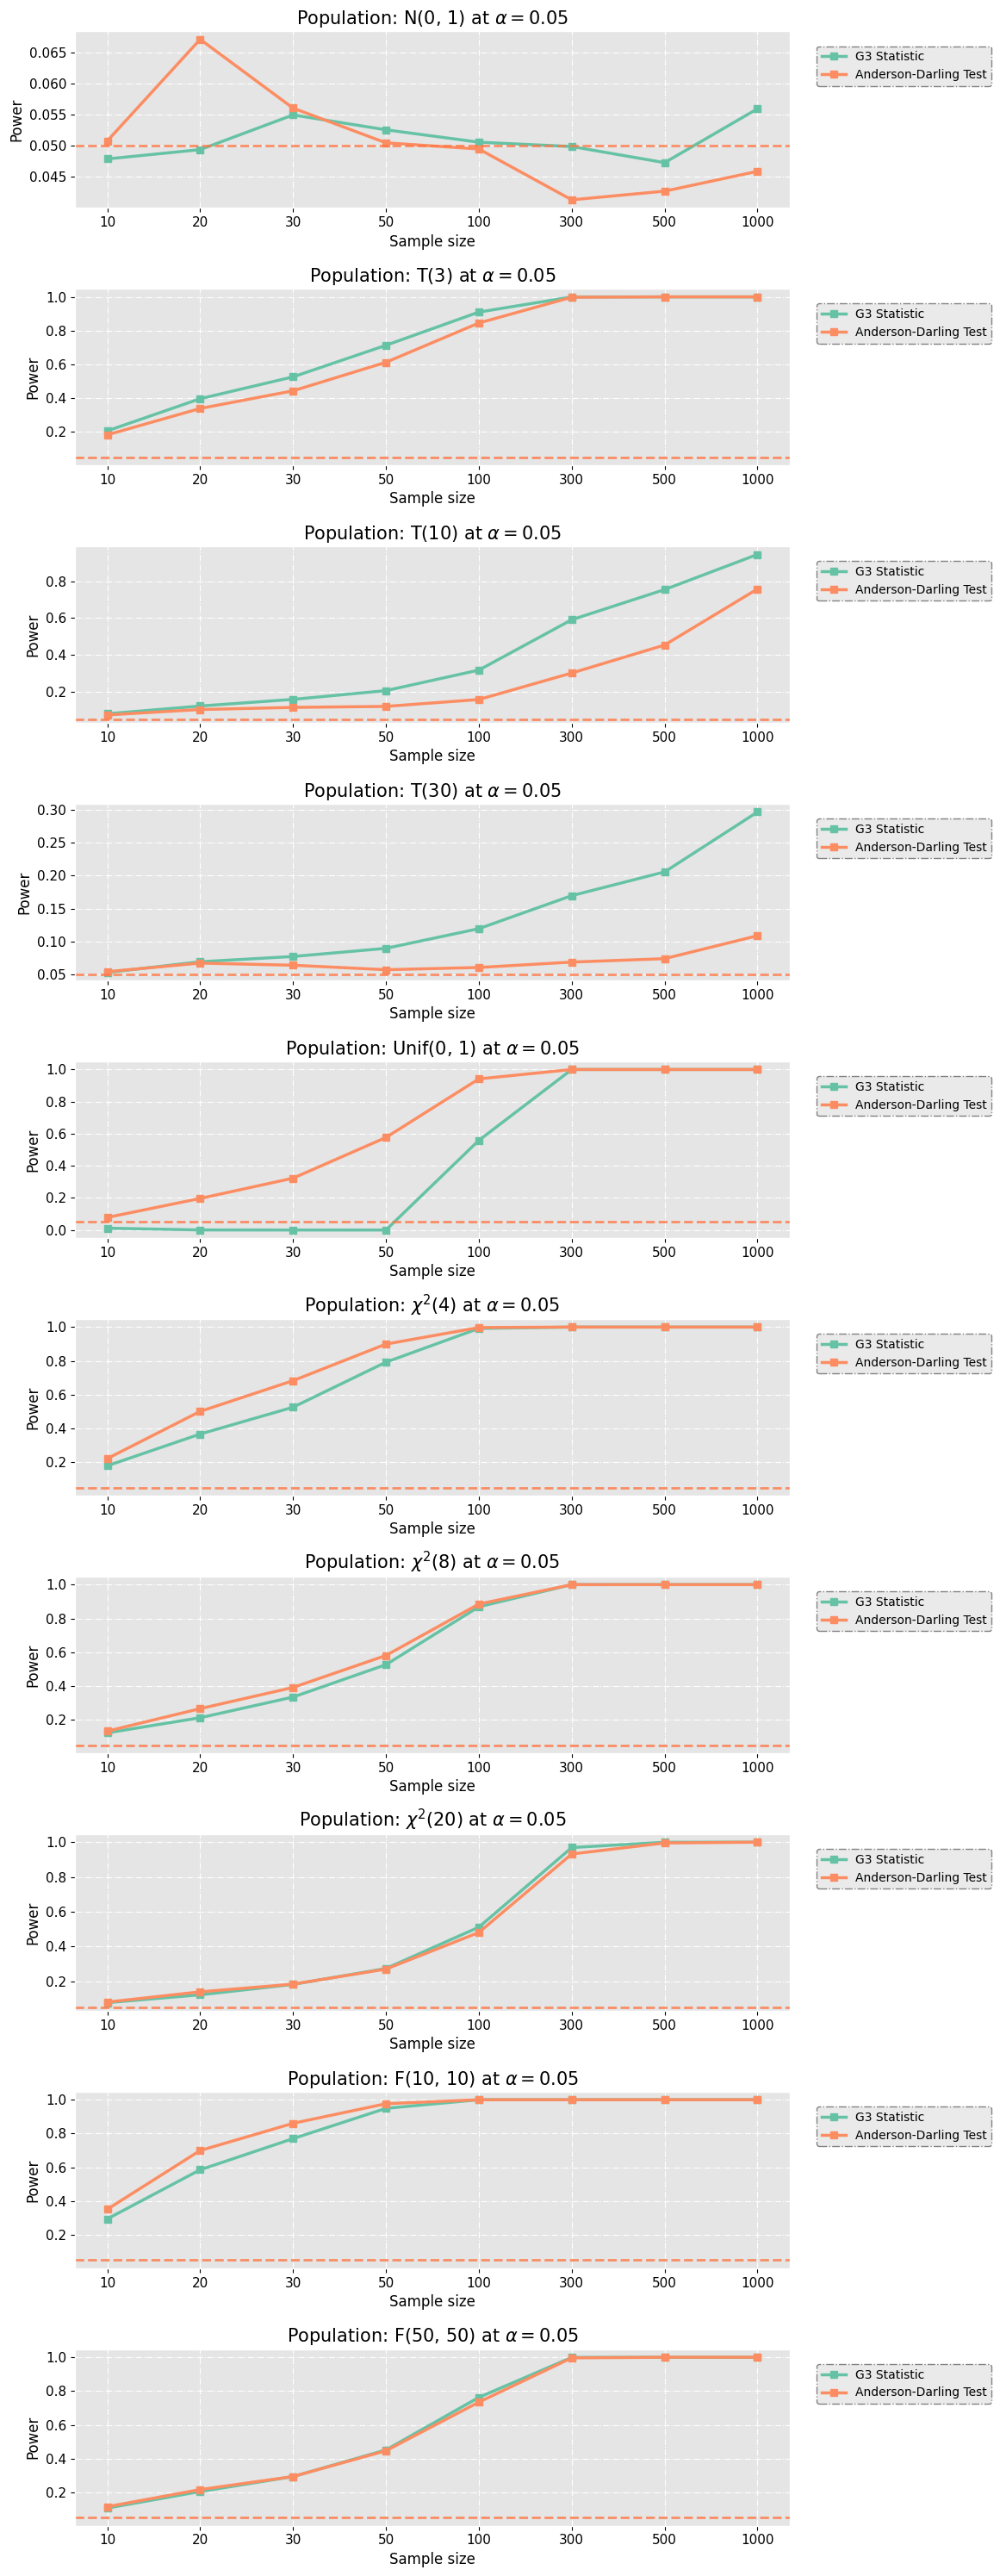

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import jarque_bera, normaltest, kstest, shapiro, anderson, cramervonmises
from statsmodels.stats.diagnostic import lilliefors
import warnings

# 忽略特定警告
warnings.filterwarnings("ignore")

# 設定參數
N = 10000  # number of samples
n = [10, 20, 30, 50, 100, 300, 500, 1000]  # sample size
alpha = 0.05

# 繪圖設定
plt.style.use('ggplot')
fig, axs = plt.subplots(10, 1, figsize = (12, 30))
def distplot(power, color, label):
    axs[k].plot(power, marker = 's', linestyle = '-', color = color, lw = 2.5, label = label)

# 開始繪圖
for k, dist_name in enumerate(distributions.keys()):

    # 初始化 power
    power_G3 = np.zeros(len(n))
    power_ad = np.zeros(len(n))

    # 計算 power for each sample size
    for i in range(len(n)):
        # 選擇分佈
        x = dist(dist_name, N, n[i])

        # 自己的 j-b test
        G3, P_Val = G3_stats(x)
        # anderson-darling test
        stat_ad = np.zeros(N)
        critical_val_ad = np.zeros(N)
        for j in range(N):
            result = anderson(x[j], dist = 'norm')
            stat_ad[j] = result.statistic
            critical_val_ad[j] = result.critical_values[2]  # 第三個臨界值，為 5% 顯著性水平

        # 計算 power
        power_G3[i] = np.mean(P_Val < alpha)
        power_ad[i] = np.mean(stat_ad > critical_val_ad)  # 檢驗統計量 > 5% 的臨界值就 reject H0

    # 繪圖
    axs = axs.ravel()
    power = [power_G3, power_ad]
    color = sns.color_palette('Set2', 8)
    label = ['G3 Statistic', 'Anderson-Darling Test']
    # 依序繪製各種檢定的 power
    for c in range(len(power)):
        distplot(power[c], color[c], label[c])
    axs[k].axhline(y = alpha, color = '#FF7744', linestyle = '--', lw = 2, alpha = 0.8)
    axs[k].set_xticks(np.arange(len(n)))
    axs[k].set_xticklabels(n)
    axs[k].set_xlabel('Sample size', fontsize = 12, color = 'black')
    axs[k].set_ylabel('Power', fontsize = 12, color = 'black')
    axs[k].set_title('Population: ' + dist_name + ' at $\\alpha = {}$'.format(alpha)
                     , fontsize = 15, color = 'black')
    axs[k].grid(True, linestyle = '-.')
    axs[k].tick_params(axis = 'both', colors = 'black', labelsize = 11)
    legend = axs[k].legend(prop = {'size': 10}, frameon = True, edgecolor = '#666666'
                          , loc = 'upper right', bbox_to_anchor = (1.29, 0.95))
    legend.get_frame().set_linestyle('-.')
    legend.get_frame().set_linewidth(1)
    legend.get_frame().set_alpha(0.8)

plt.tight_layout()
plt.show()

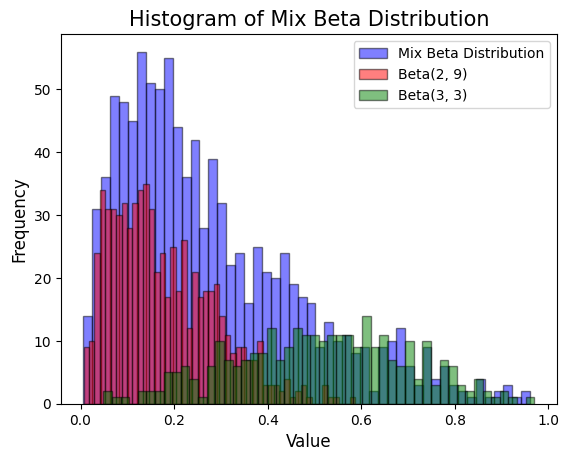

In [ ]:
# 生成 mix beta distribution，第一個 beta 分佈的參數為 (2, 9)，第二個 beta 分佈的參數為 (3， 3)，第一個分佈的比例為 0.7
# ， 第二個分佈的比例為 0.3， size = 1000，生成該筆資料，並畫出 histogram
from scipy.stats import beta, binom
import numpy as np
import matplotlib.pyplot as plt

# 生成 mix beta distribution
size = 1000
p = 0.7
a1, b1 = 2, 9
a2, b2 = 3, 3
# n1 = int(size * p)
n1 = binom.rvs(size, p)
# n2 = int(size * (1 - p))
n2 = size - n1
x1 = beta.rvs(a1, b1, size = n1)
x2 = beta.rvs(a2, b2, size = n2)
X = np.concatenate([x1, x2])
plt.hist(X, bins = 50, color = 'blue', edgecolor = 'black', alpha = 0.5, label = 'Mix Beta Distribution')
plt.hist(beta.rvs(a1, b1, size = int(size * p)), bins = 50, color = 'red', edgecolor = 'black'
         , alpha = 0.5, label = 'Beta(2, 9)')
plt.hist(beta.rvs(a2, b2, size = int(size * (1 - p))), bins = 50, color = 'green'
         , edgecolor = 'black', alpha = 0.5, label = 'Beta(3, 3)')
plt.title('Histogram of Mix Beta Distribution', fontsize = 15)
plt.xlabel('Value', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
# plt.grid(True, linestyle = '-.')
plt.legend()
plt.show()

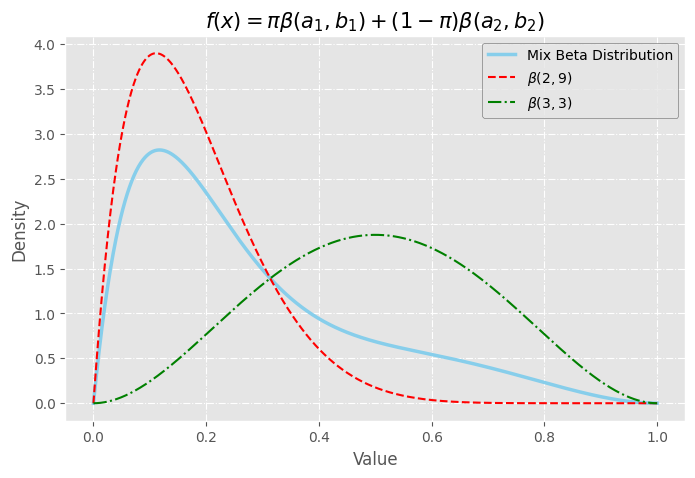

In [13]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

size = 1000
p = 0.7
a1, b1 = 2, 9
a2, b2 = 3, 3
f = lambda x: p * beta.pdf(x, a1, b1) + (1 - p) * beta.pdf(x, a2, b2)
x = np.linspace(0, 1, 1000)
y = f(x)
fig = plt.figure(figsize = (8, 5))
plt.plot(x, y, color = 'skyblue', lw = 2.5, label = 'Mix Beta Distribution')
plt.plot(x, beta.pdf(x, a1, b1), color = 'red', lw = 1.5, linestyle = '--', label = '$\\beta(2, 9)$')
plt.plot(x, beta.pdf(x, a2, b2), color = 'green', lw = 1.5, linestyle = '-.', label = '$\\beta(3, 3)$')
plt.title('$f(x) = \\pi \\beta(a_1, b_1) + (1 - \\pi) \\beta(a_2, b_2)$', fontsize = 15)
plt.xlabel('Value', fontsize = 12)
plt.ylabel('Density', fontsize = 12)
plt.grid(True, linestyle = '-.')
plt.legend(prop = {'size': 10}, frameon = True, edgecolor = '#666666')
plt.show()

In [20]:
from scipy.stats import beta
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# 生成 mix beta distribution 的樣本
size = 1000
p = 0.7
a1, b1 = 2, 9
a2, b2 = 3, 3
n1 = binom.rvs(size, p)
n2 = size - n1
x1 = beta.rvs(a1, b1, size = n1)
x2 = beta.rvs(a2, b2, size = n2)
X = np.concatenate([x1, x2])


# 定義出 mixed beta 對數概似函數
def log_likelihood(p, a1, b1, a2, b2):
    return np.sum(np.log(p * beta.pdf(X, a1, b1) + (1 - p) * beta.pdf(X, a2, b2)))

initial_params = [0.7, 2, 9, 3, 3]
result = minimize(lambda x: -log_likelihood(x[0], x[1], x[2], x[3], x[4]), [0.7, 2, 9, 3, 3]
                  , bounds = [(0, 1), (0, None), (0, None), (0, None), (0, None)])
print(result)



  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -380.7420893804067
        x: [ 4.046e-01  2.561e+00  1.497e+01  1.699e+00  2.804e+00]
      nit: 24
      jac: [-1.819e-04 -2.274e-05 -2.274e-05  4.547e-05 -1.080e-04]
     nfev: 192
     njev: 32
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
